In [37]:
from read_csv import read_csv05
from read_csv import read_csv10
from read_csv import read_csv20
import numpy as np
import matplotlib.pyplot as plt

In [38]:
data05 = read_csv05('database/data05.csv')
data10 = read_csv10('database/data10.csv')
data20 = read_csv20('database/data20.csv')
print(data05.shape)
print(data10.shape)
print(data20.shape)

mean05 = np.mean(data05, axis=1)
mean10 = np.mean(data10, axis=1)
mean20 = np.mean(data20, axis=1)


(5, 100)
(10, 10)
(20, 5)


<BarContainer object of 5 artists>

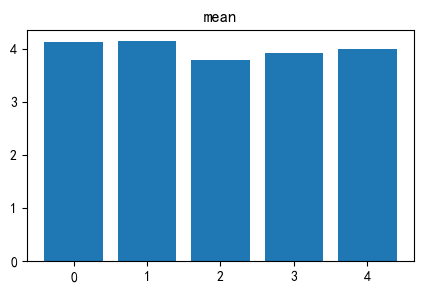

In [39]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (5,3)
plt.title("mean")
x=range(5)
plt.bar(x,mean05)

(0.0, 0.5)

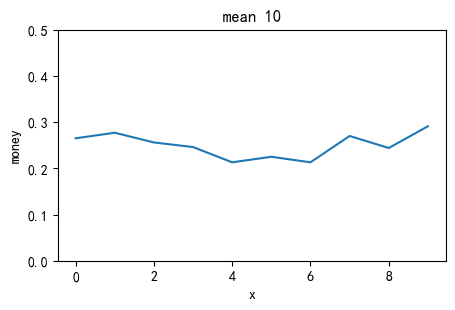

In [40]:
x = range(10)
plt.plot(x, mean10)
plt.title("mean 10")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)

(0.0, 0.5)

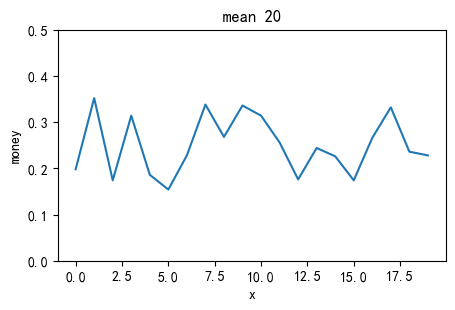

In [41]:
x = range(20)
plt.plot(x, mean20)
plt.title("mean 20")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)